# 🌍 EuroSAT Multispectral Dataset: A Deep Dive

## Notebook Overview

Welcome! This notebook provides a comprehensive visual and statistical exploration of the **EuroSAT multispectral (MS) dataset**. The EuroSAT dataset contains satellite images from Sentinel-2, which captures light across 13 different spectral bands—many of which are beyond what the human eye can see.

Our goal is to understand the unique **spectral signature** (like a spectral fingerprint) for each land cover class. We will do this by visualizing images and analyzing their underlying data.

--- 

### What You'll Learn:

1.  **✔️ Dataset Validation**: We'll start by checking the dataset's structure and counting the number of images in each land cover category.
2.  **🎨 Image Visualization**: We will look at sample images from each class in two ways:
    * **True Color (RGB)**: How we would naturally see it.
    * **Spectral Index**: A calculated view (like NDVI) that highlights specific features, such as vegetation health or water content.
3.  **📈 Statistical Analysis**: We will process thousands of images to calculate the average reflectance for each of the 13 spectral bands, revealing the unique signature of each class.
4.  **🔍 Signature Plotting**: Finally, we'll plot these signatures on a graph and a heatmap for easy comparison.

## ⚙️ Step 1: Setup and Environment Configuration

This first step is crucial. We will import all the necessary Python libraries for data handling, image processing, and visualization. We also configure the path to the dataset and perform a quick validation to make sure everything is in place before we begin our analysis.

In [3]:
# ====== STEP 1: Dataset Setup and Validation ======

# --- Core Libraries ---
from pathlib import Path      # For handling file system paths in an OS-agnostic way
import pandas as pd           # For data manipulation and creating dataframes
import numpy as np            # For numerical operations, especially with arrays
import matplotlib.pyplot as plt # For creating plots and visualizations
import seaborn as sns         # For creating more attractive and informative statistical graphics
import rasterio               # The primary library for reading and writing satellite image files (like GeoTIFFs)
from datetime import datetime # To timestamp the start of our script
import warnings               # To control warning messages
import random                 # To select a random sample of images for analysis

# --- Suppress a common, non-critical warning from rasterio ---
warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)

# --- Configure Visualization Style ---
# This ensures our plots look clean and consistent throughout the notebook.
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl") # Use a color-blind friendly palette

print(f"🚀 Starting EuroSAT Dataset Overview at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 65)

# --- ❗ IMPORTANT: Path Configuration ❗ ---
# Update the DATA_DIR variable below with the correct path to your 'EuroSAT_MS' folder.
DATA_DIR = Path("T:\DEPI final Project\EuroSAT_MS")

# --- Data Validation ---
# The following code checks if the path is correct and if class folders exist.
if not DATA_DIR.exists():
    raise FileNotFoundError(
        f"❌ ERROR: Dataset folder not found at: {DATA_DIR.resolve()}\n"
        f"Please update the DATA_DIR variable with the correct path."
    )
print(f"✅ Dataset folder found: {DATA_DIR.resolve()}")

# Get a sorted list of all class names (which are the directory names)
classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
if not classes:
    raise FileNotFoundError(
        f"❌ ERROR: No class folders found inside {DATA_DIR.resolve()}\n"
        f"Expected folders like 'AnnualCrop', 'River', etc."
    )
print(f"✅ Found {len(classes)} land cover classes.")

# --- Dataset Overview ---
# Count the number of '.tif' images in each class folder.
print("\n📊 Dataset Composition (Image Count per Class):")
counts = {}
for c in classes:
    count = len(list((DATA_DIR / c).glob("*.tif")))
    counts[c] = count
    status = "✅" if count > 0 else "⚠️"
    print(f"  {status} {c:<20} : {count:,} images")

print("\n✨ Setup completed successfully! Ready for multi-class analysis.")

🚀 Starting EuroSAT Dataset Overview at 2025-09-19 00:40:14
✅ Dataset folder found: T:\DEPI final Project\EuroSAT_MS
✅ Found 10 land cover classes.

📊 Dataset Composition (Image Count per Class):
  ✅ AnnualCrop           : 2,000 images
  ✅ Forest               : 2,000 images
  ✅ HerbaceousVegetation : 2,000 images
  ✅ Highway              : 2,000 images
  ✅ Industrial           : 2,000 images
  ✅ Pasture              : 2,000 images
  ✅ PermanentCrop        : 2,000 images
  ✅ Residential          : 2,000 images
  ✅ River                : 2,000 images
  ✅ SeaLake              : 2,000 images

✨ Setup completed successfully! Ready for multi-class analysis.


<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tadoa\AppData\Local\Temp\ipykernel_19208\2666059037.py:27: SyntaxWarning: invalid escape sequence '\D'
  DATA_DIR = Path("T:\DEPI final Project\EuroSAT_MS")


### Visualizing Class Distribution

Now, let's create a bar chart to visualize how many images we have for each class. This helps us see if the dataset is **balanced** (i.e., has a similar number of images for each class).

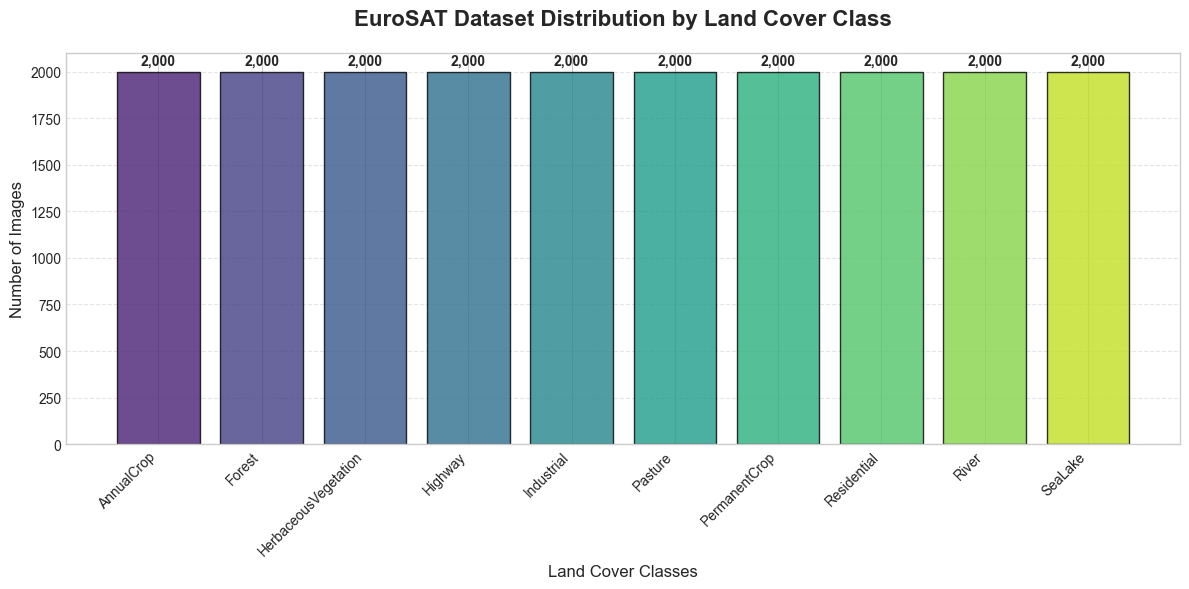

In [4]:
# --- Visualize Dataset Distribution ---
plt.figure(figsize=(12, 6))

# Sort classes by the number of images in descending order for a cleaner plot
classes_sorted = sorted(counts.keys(), key=lambda x: counts[x], reverse=True)
values = [counts[c] for c in classes_sorted]

# Create the bar plot
bars = plt.bar(classes_sorted, values, color=sns.color_palette("viridis", len(classes)), alpha=0.8, edgecolor='black')

# Set titles and labels for clarity
plt.title('EuroSAT Dataset Distribution by Land Cover Class', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Land Cover Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.grid(axis='y', alpha=0.5, linestyle='--')

# Add the exact count on top of each bar
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 20, # Position text slightly above the bar
        f'{value:,}', 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## 🎨 Step 2: Comparative Image Visualization

Seeing is believing! In this step, we'll visually inspect sample images from each class. For each image, we'll show two views:

1.  **True Color (RGB)**: This is a composite of the Red (B4), Green (B3), and Blue (B2) bands, representing what our eyes would see.
2.  **Spectral Index**: This is a calculation using different spectral bands to highlight certain features.
    * **NDVI (Normalized Difference Vegetation Index)**: Excellent for identifying healthy vegetation. It uses the Red and Near-Infrared (NIR) bands. High values (green) mean healthy plants.
    * **NDWI (Normalized Difference Water Index)**: Ideal for spotting water bodies. It uses the Green and NIR bands. High values (blue) indicate water.

In [5]:
# ====== STEP 2.1: Helper Functions for Visualization ======

def enhanced_stretch(x, percentiles=(2, 98), gamma=1.0):
    """
    Applies a contrast stretch to image data for better visualization.
    
    This function takes an image array, finds the 2nd and 98th percentile values, 
    and stretches this range to the full 0-1 display range, clipping outliers.
    This makes images appear less washed out or dark.
    """
    x = x.astype(np.float32)
    # Use only valid (non-zero) pixels to calculate percentiles
    valid_pixels = x[x > 0]
    if valid_pixels.size == 0:
        return np.zeros_like(x) # Return a black image if no valid pixels
        
    # Calculate the percentile values
    lo, hi = np.percentile(valid_pixels, percentiles)
    
    # Stretch the data and clip it to a 0-1 range
    stretched = np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)
    
    # Apply gamma correction to adjust brightness
    return np.power(stretched, 1/gamma)

def get_relevant_index(class_name):
    """
    Selects the most appropriate spectral index and color map for a given class.
    For vegetation, we use NDVI. For water, we use NDWI.
    """
    if class_name in ['AnnualCrop', 'PermanentCrop', 'Forest', 'HerbaceousVegetation', 'Pasture']:
        return 'NDVI', 'RdYlGn' # Red-Yellow-Green colormap is intuitive for vegetation
    elif class_name in ['River', 'SeaLake']:
        return 'NDWI', 'Blues' # Shades of blue for water
    else: # For classes like buildings or highways
        return 'NDVI', 'viridis' # Viridis is a good general-purpose colormap

def calculate_index(band_cache, index_name):
    """
    Calculates NDVI or NDWI from a cache of Sentinel-2 bands.
    The formulas are:
    - NDVI = (NIR - Red) / (NIR + Red)
    - NDWI = (Green - NIR) / (Green + NIR)
    """
    # Add a small epsilon (1e-6) to the denominator to prevent division by zero
    if index_name == 'NDVI':
        nir_band = band_cache[8].astype(np.float32)
        red_band = band_cache[4].astype(np.float32)
        denominator = nir_band + red_band
        index = np.divide(nir_band - red_band, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    elif index_name == 'NDWI':
        green_band = band_cache[3].astype(np.float32)
        nir_band = band_cache[8].astype(np.float32)
        denominator = green_band + nir_band
        index = np.divide(green_band - nir_band, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    else:
        # Return an empty array if the index is not recognized
        return np.zeros_like(band_cache[1])
        
    # The index value should always be between -1 and 1
    return np.clip(index, -1, 1)


==================== AnnualCrop ====================



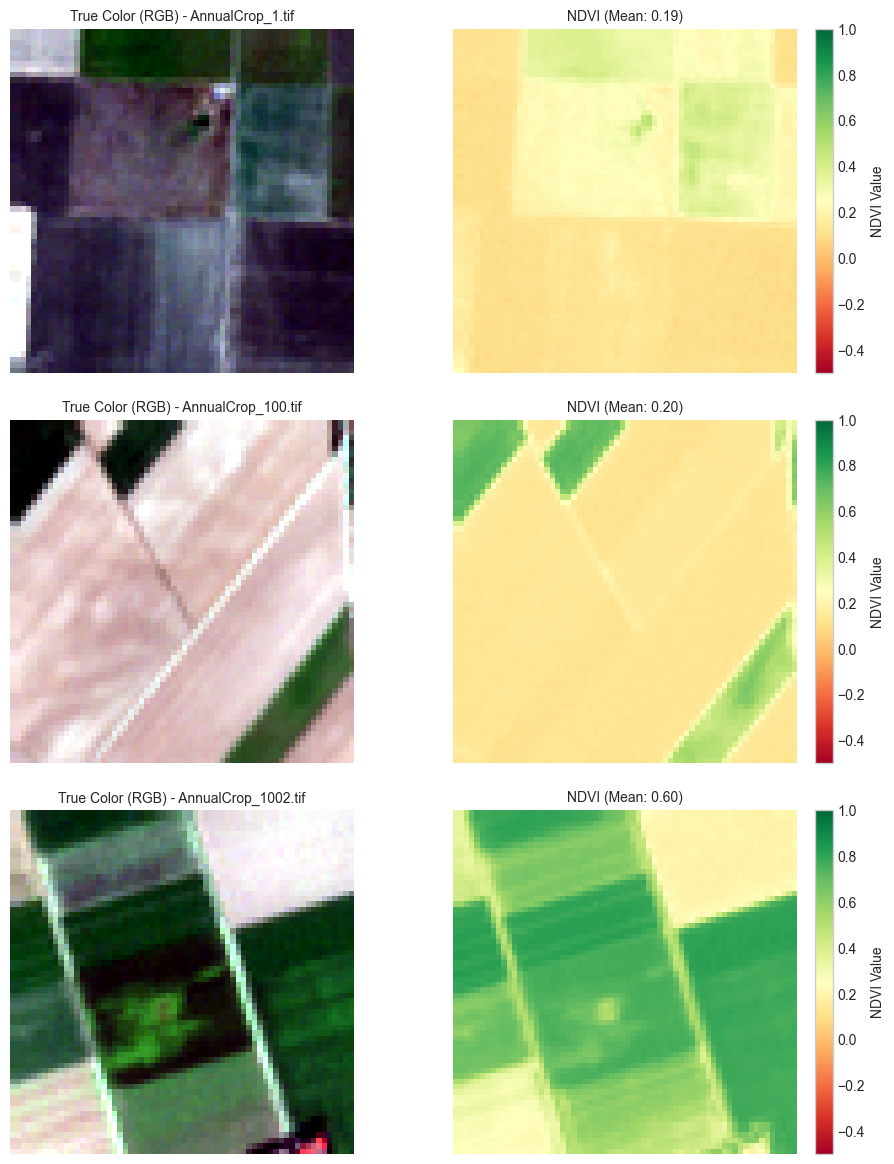


==================== Forest ====================



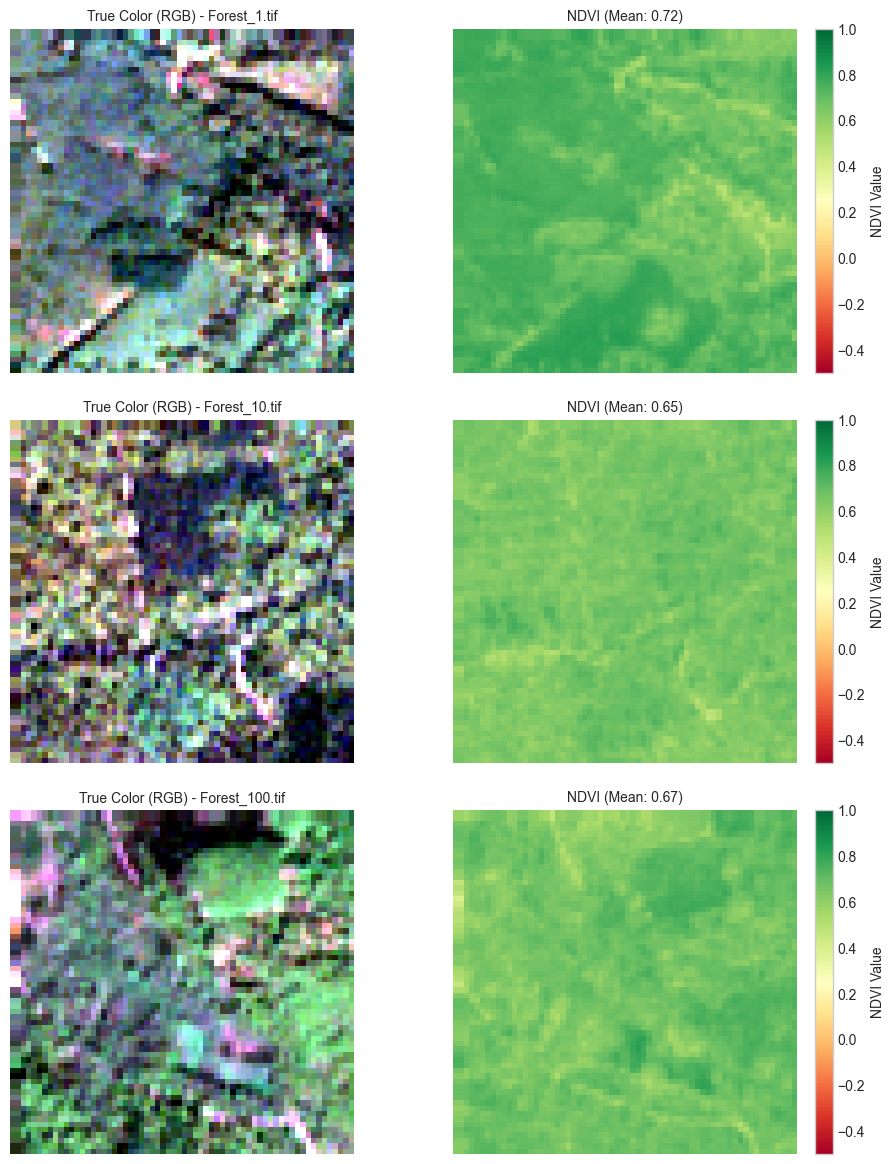


==================== HerbaceousVegetation ====================



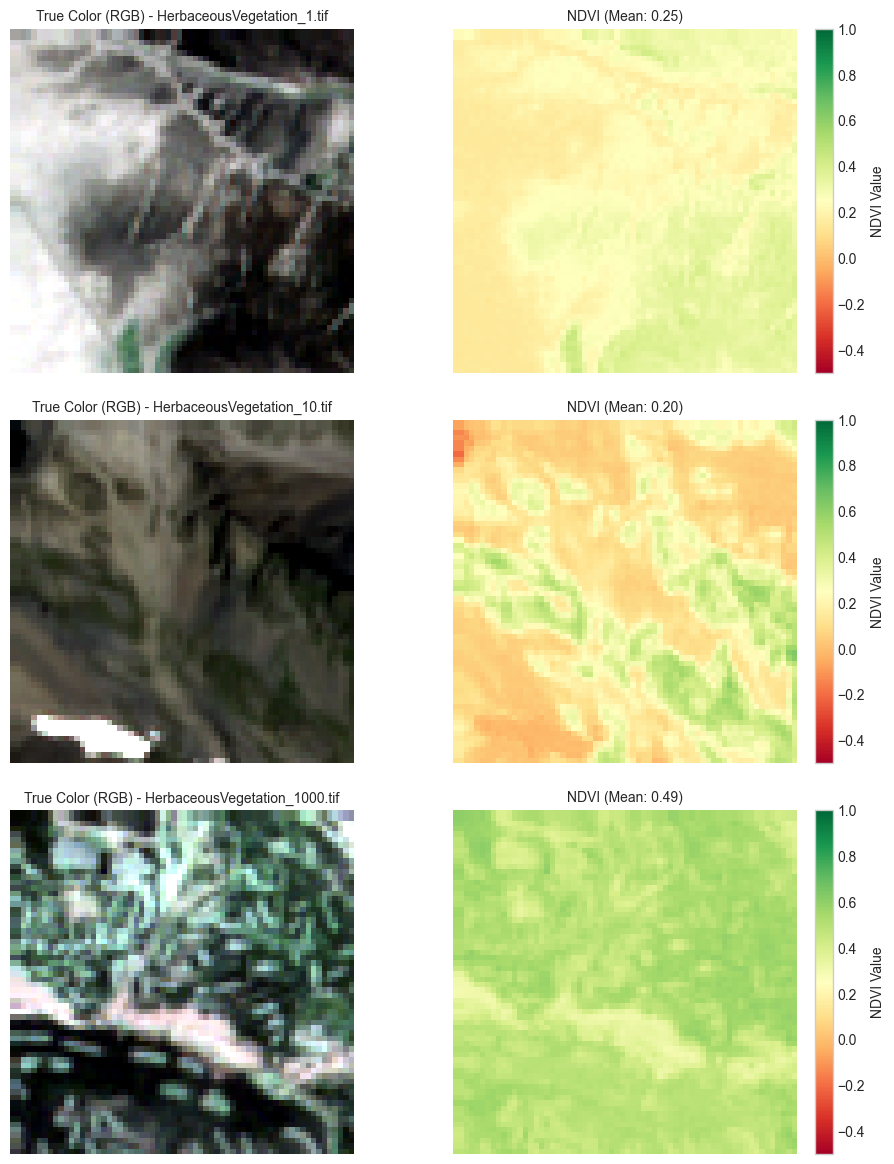


==================== Highway ====================



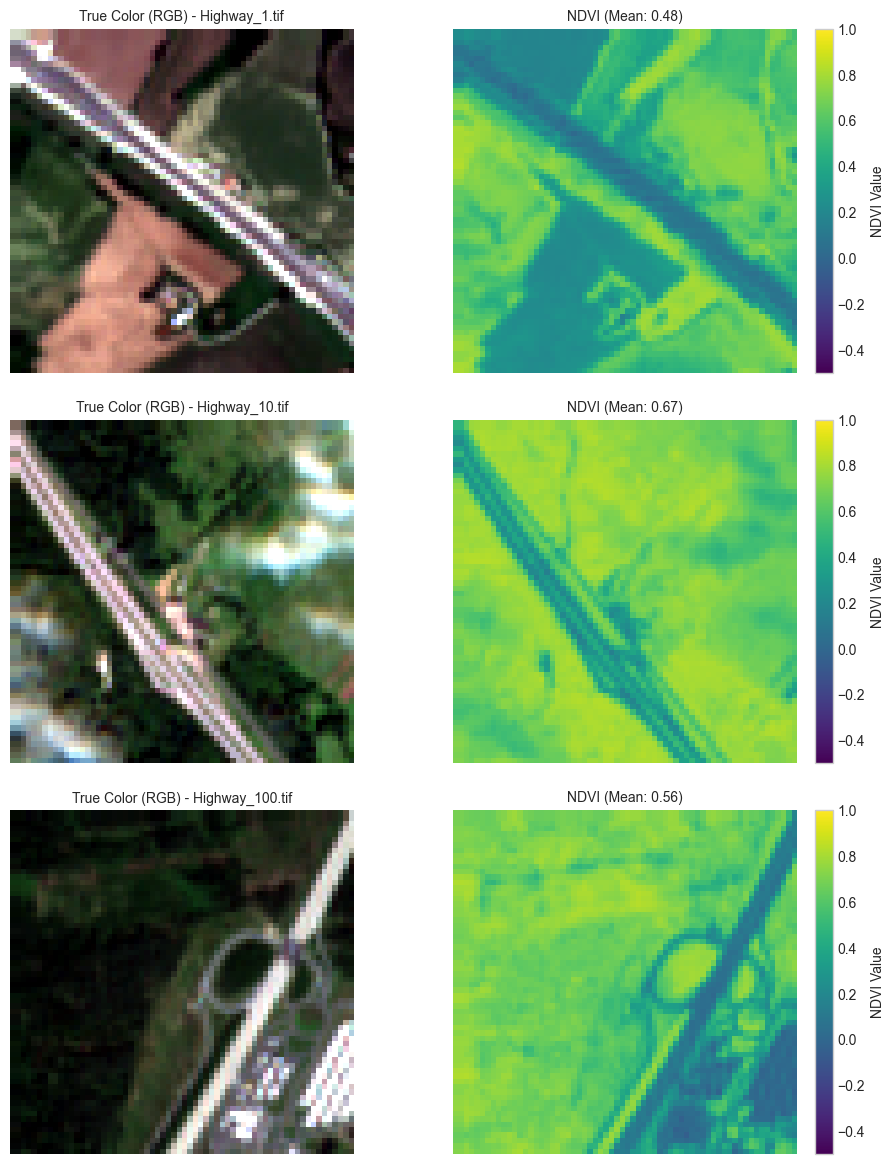


==================== Industrial ====================



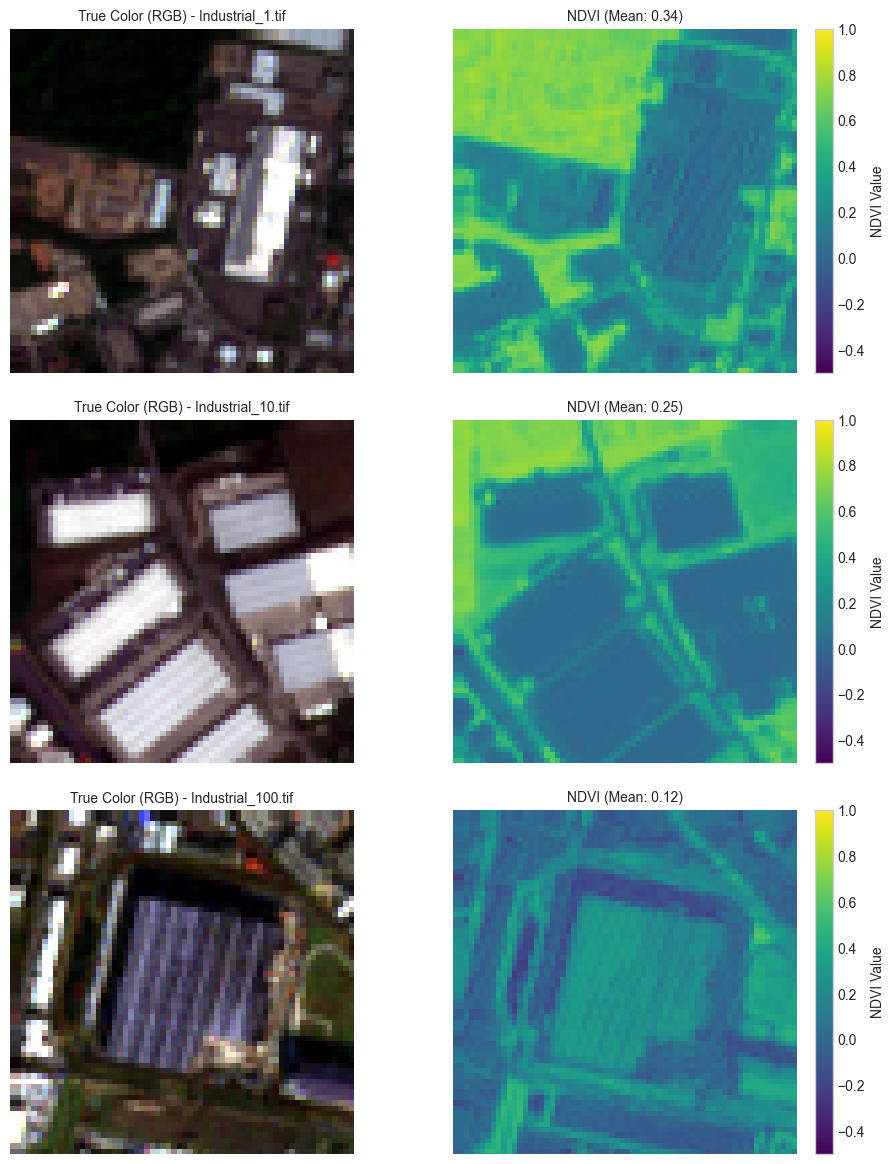


==================== Pasture ====================



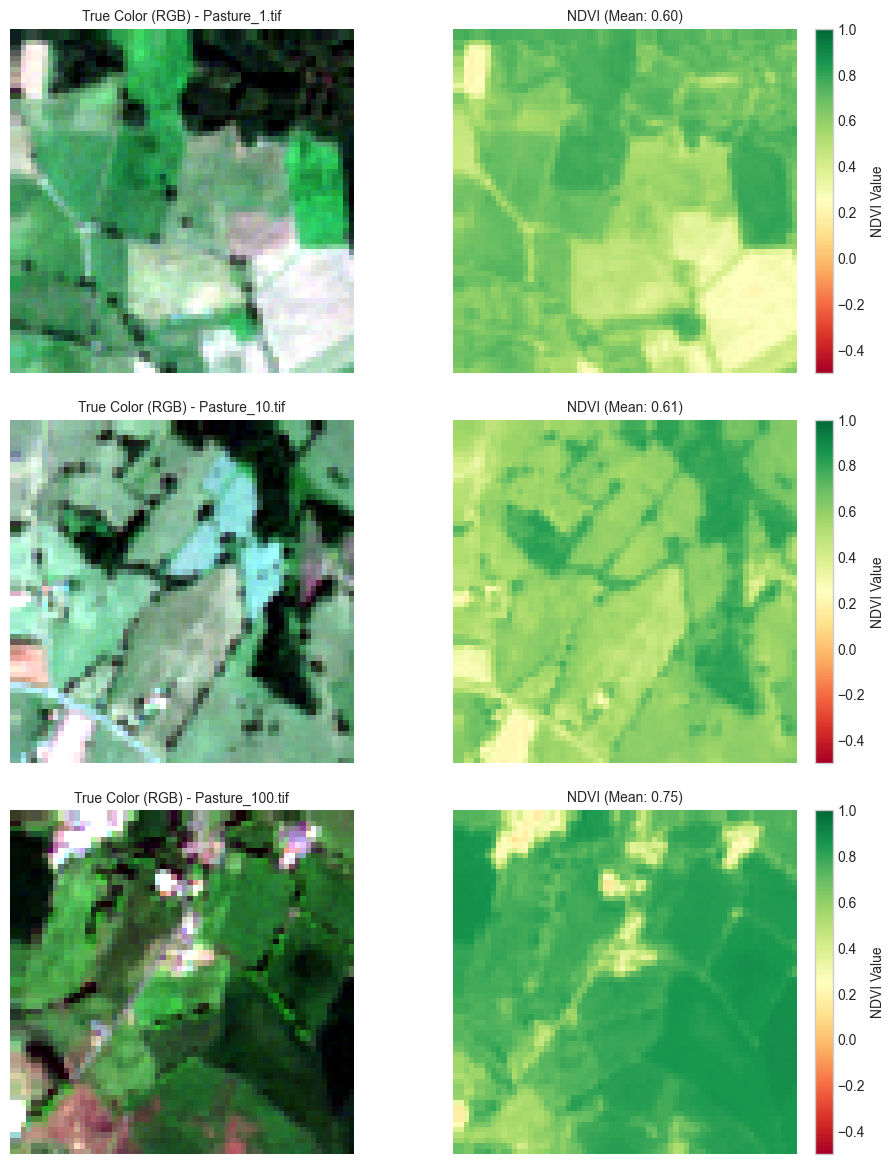


==================== PermanentCrop ====================



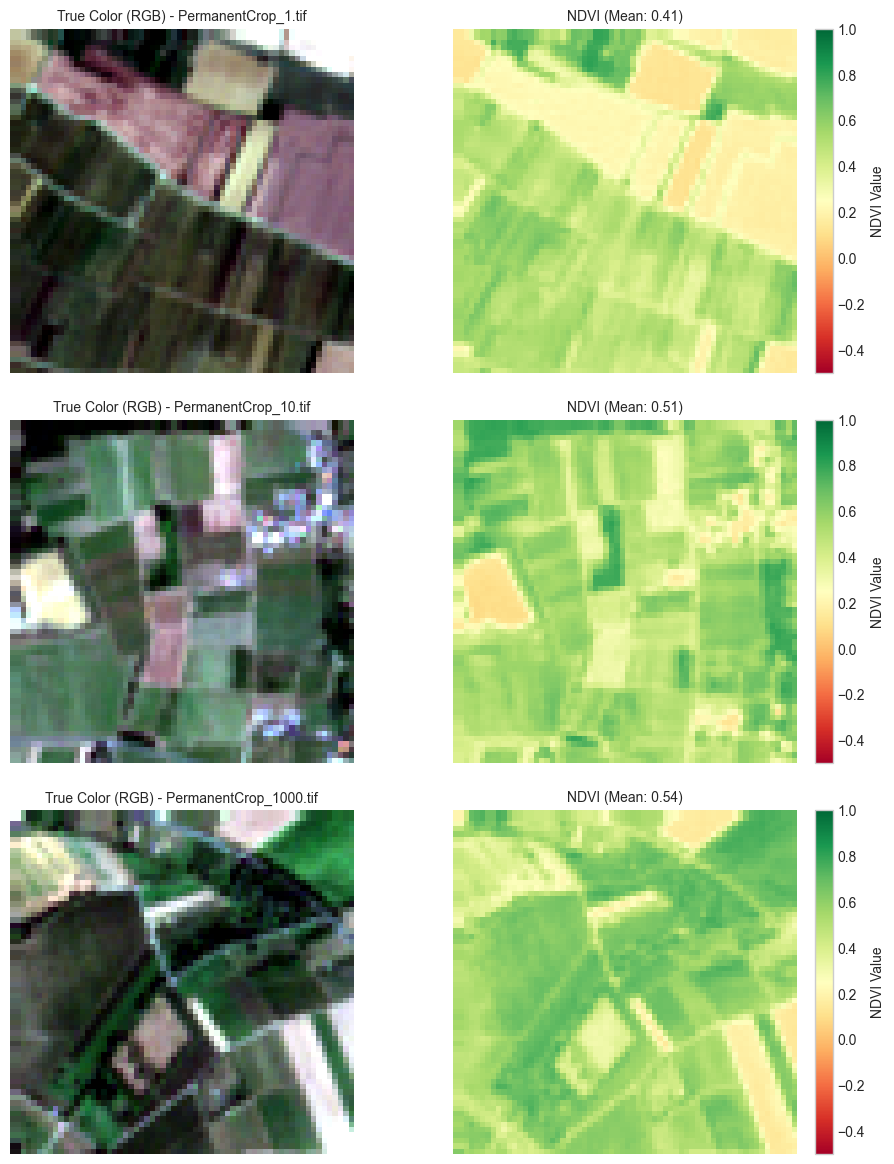


==================== Residential ====================



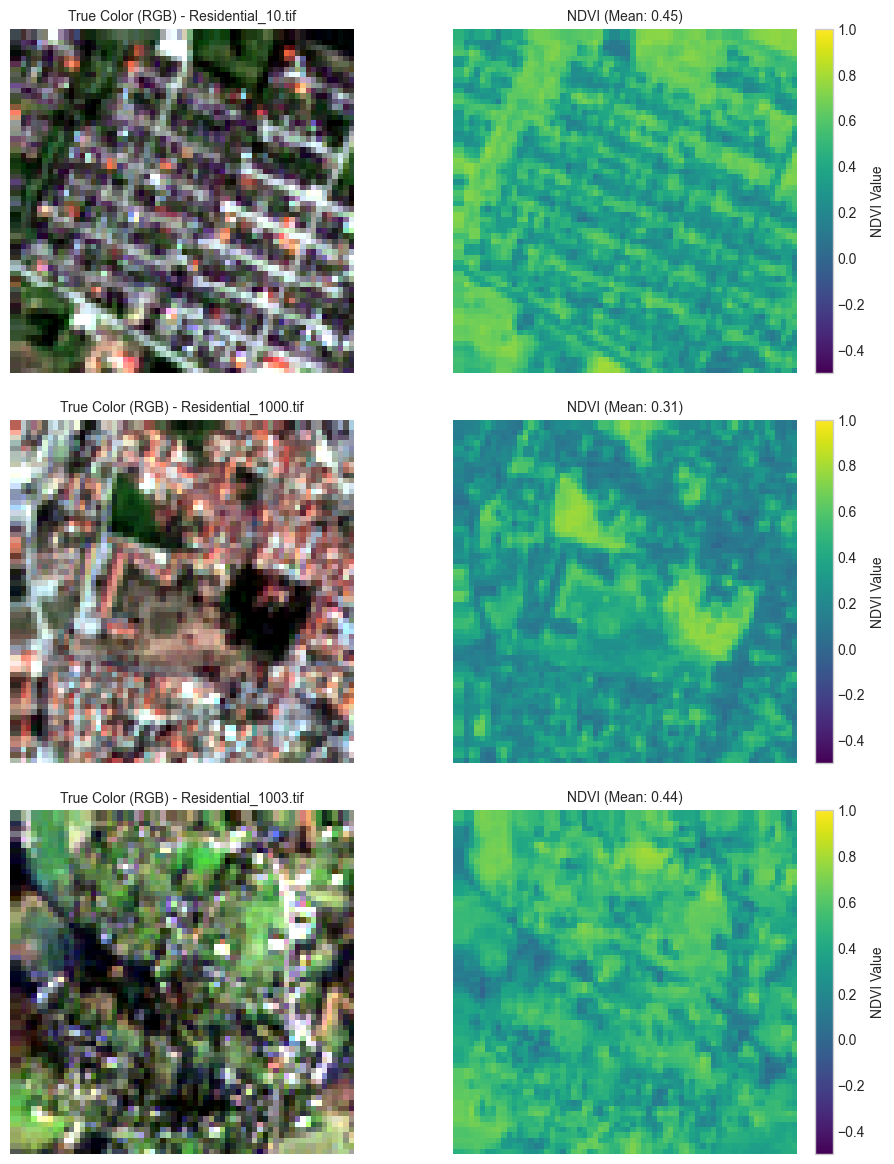


==================== River ====================



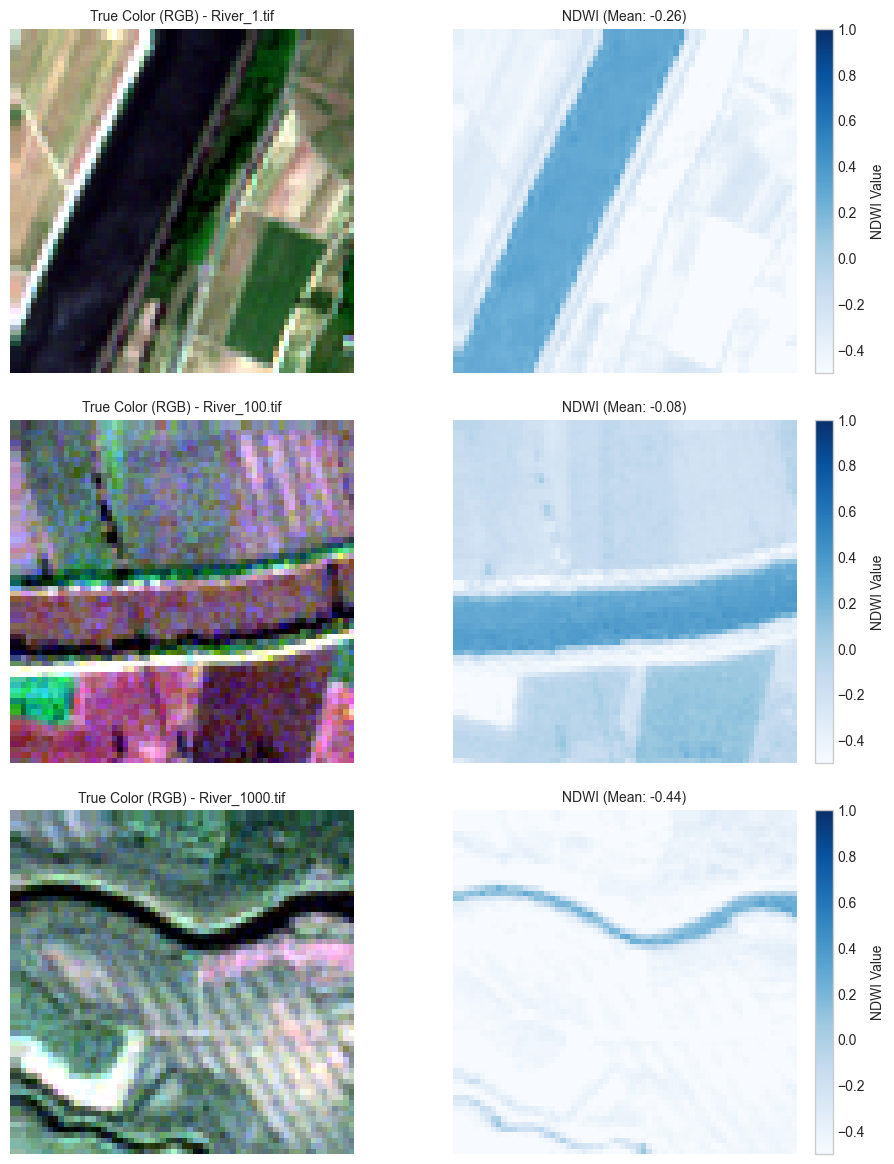


==================== SeaLake ====================



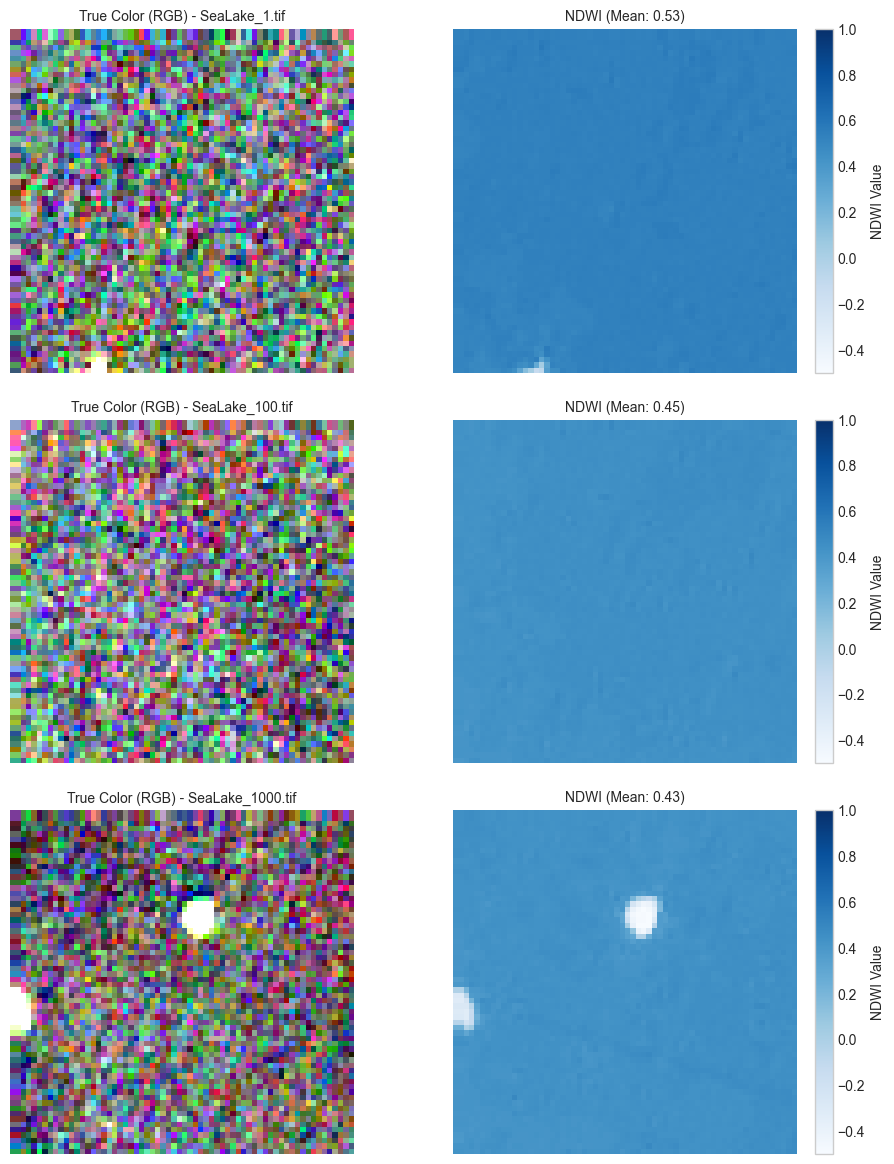


✅ All sample images processed and displayed.


In [6]:
# ====== STEP 2.2: Display Sample Images from Each Class ======

# Loop through each class we found in Step 1
for CLASS_NAME in classes:
    class_dir = DATA_DIR / CLASS_NAME
    files = sorted(list(class_dir.glob("*.tif")))
    
    if not files:
        print(f"  ⚠️ No images found for class: {CLASS_NAME}")
        continue
        
    # Select up to 3 sample files to display
    sample_files = files[:3]

    # Get the best index (NDVI or NDWI) for this class
    index_name, cmap = get_relevant_index(CLASS_NAME)

    print(f"\n{'='*20} {CLASS_NAME} {'='*20}\n")
    
    # Create a plot figure. The size will adapt to the number of samples.
    fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 4 * len(sample_files)), squeeze=False)

    for i, sample_file in enumerate(sample_files):
        try:
            with rasterio.open(sample_file) as src:
                # Read all bands into a dictionary for easy access. This is our 'band_cache'.
                band_cache = {b: src.read(b) for b in range(1, src.count + 1)}

                # --- Create True Color (RGB) composite ---
                # We stack the stretched Red, Green, and Blue bands.
                rgb_composite = np.dstack([
                    enhanced_stretch(band_cache[4]), # Red (B4)
                    enhanced_stretch(band_cache[3]), # Green (B3)
                    enhanced_stretch(band_cache[2])  # Blue (B2)
                ])

                # --- Calculate the relevant spectral index ---
                index_map = calculate_index(band_cache, index_name)
                mean_index_value = np.nanmean(index_map[index_map != 0]) # Calculate mean, ignoring no-data pixels

                # --- Plot the RGB image ---
                ax_rgb = axes[i, 0]
                ax_rgb.imshow(rgb_composite)
                ax_rgb.set_title(f'True Color (RGB) - {sample_file.name}', fontsize=10)
                ax_rgb.axis('off')
                
                # --- Plot the Spectral Index ---
                ax_idx = axes[i, 1]
                im = ax_idx.imshow(index_map, cmap=cmap, vmin=-0.5, vmax=1)
                ax_idx.set_title(f'{index_name} (Mean: {mean_index_value:.2f})', fontsize=10)
                ax_idx.axis('off')
                
                # Add a color bar to explain the index values
                fig.colorbar(im, ax=ax_idx, fraction=0.046, pad=0.04, label=f'{index_name} Value')

        except Exception as e:
            print(f"  ❌ Error processing image {sample_file.name}: {e}")

    plt.tight_layout(pad=2.0)
    plt.show()

print("\n✅ All sample images processed and displayed.")
print("=" * 65)

## 📊 Step 3: Large-Scale Spectral Statistics

Now we move from looking at individual images to analyzing data in bulk. The goal here is to compute the **average spectral signature** for each land cover class.

A **spectral signature** is a plot showing how much light a material reflects at different wavelengths. For example, healthy vegetation reflects a lot of near-infrared light (which we can't see) and absorbs red light. This unique pattern is its signature.

To do this, we will:
1.  Take a large random sample of images from all classes.
2.  For each image, calculate the average pixel value (reflectance) for all 13 bands.
3.  Aggregate these statistics to find the overall mean reflectance per band for each class.
4.  Plot these signatures to compare them.

This process is computationally intensive, so we'll use **multi-threading** to speed it up significantly.

### Sentinel-2 Band Information

Before we start, here is a quick reference for the 13 bands provided by the Sentinel-2 satellite. Note the different wavelengths and spatial resolutions.

In [7]:
# ====== STEP 3.1: Band Information and Helper Functions ======

# A dictionary containing metadata for each Sentinel-2 band
SENTINEL2_BANDS = {
     1: {'name': 'B01-Coastal',    'wavelength': '443nm',  'resolution': 60},
     2: {'name': 'B02-Blue',       'wavelength': '490nm',  'resolution': 10},
     3: {'name': 'B03-Green',      'wavelength': '560nm',  'resolution': 10},
     4: {'name': 'B04-Red',        'wavelength': '665nm',  'resolution': 10},
     5: {'name': 'B05-RedEdge1',   'wavelength': '705nm',  'resolution': 20},
     6: {'name': 'B06-RedEdge2',   'wavelength': '740nm',  'resolution': 20},
     7: {'name': 'B07-RedEdge3',   'wavelength': '783nm',  'resolution': 20},
     8: {'name': 'B08-NIR',        'wavelength': '842nm',  'resolution': 10},
     9: {'name': 'B09-WaterVapor', 'wavelength': '945nm',  'resolution': 60},
    10: {'name': 'B10-Cirrus',     'wavelength': '1375nm', 'resolution': 60},
    11: {'name': 'B11-SWIR1',      'wavelength': '1610nm', 'resolution': 20},
    12: {'name': 'B12-SWIR2',      'wavelength': '2190nm', 'resolution': 20},
    13: {'name': 'B8A-NIRNarrow',  'wavelength': '865nm',  'resolution': 20},
}

# Display this information in a clean table (DataFrame)
band_info_df = pd.DataFrame.from_dict(SENTINEL2_BANDS, orient='index')
band_info_df.index.name = 'Band #'
print("📋 Sentinel-2 Band Reference Table:")
display(band_info_df)

def per_band_stats(arr: np.ndarray):
    """Computes key statistics for a single band's array of pixels."""
    x = arr.astype(np.float32)
    valid_pixels = x[x > 0] # Exclude no-data values, which are often 0
    if valid_pixels.size == 0:
        return {'mean': np.nan, 'std': np.nan, 'p05': np.nan, 'p95': np.nan}
    
    return {
        'mean': float(valid_pixels.mean()),
        'std': float(valid_pixels.std()),
        'p05': float(np.percentile(valid_pixels, 5)), # 5th percentile
        'p95': float(np.percentile(valid_pixels, 95)), # 95th percentile
    }

def process_image_for_stats(filepath):
    """
    Opens a single GeoTIFF image, calculates stats for each band, and returns them.
    Designed to be run in a separate thread for parallel processing.
    """
    try:
        with rasterio.open(filepath) as src:
            stats = {'filename': filepath.name, 'class': filepath.parent.name}
            for b in range(1, src.count + 1):
                band_array = src.read(b)
                band_stats = per_band_stats(band_array)
                for stat_name, value in band_stats.items():
                    stats[f'b{b:02d}_{stat_name}'] = value
            return stats, None # Return result and no error
    except Exception as e:
        return None, f"Error processing {filepath.name}: {e}" # Return no result and an error message

📋 Sentinel-2 Band Reference Table:


,name,wavelength,resolution
Band #,,,
1,B01-Coastal,443nm,60
2,B02-Blue,490nm,10
3,B03-Green,560nm,10
4,B04-Red,665nm,10
5,B05-RedEdge1,705nm,20
6,B06-RedEdge2,740nm,20
7,B07-RedEdge3,783nm,20
8,B08-NIR,842nm,10
9,B09-WaterVapor,945nm,60


In [8]:
# ====== STEP 3.2: Parallel Processing of Images ======
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import time

# --- Configuration ---
MAX_SAMPLES = 4000  # Max number of images to analyze. Increase for more precision, decrease for speed.
N_THREADS   = 8     # Number of parallel threads. Adjust based on your CPU cores.

# Get a list of all image files from all class directories
all_files = [f for c in classes for f in (DATA_DIR / c).glob("*.tif")]

# Select a random sample of files to process
if len(all_files) > MAX_SAMPLES:
    selected_files = random.sample(all_files, MAX_SAMPLES)
    print(f"📁 Analyzing a random sample of {len(selected_files):,} images (out of {len(all_files):,} total).")
else:
    selected_files = all_files
    print(f"📁 Analyzing all {len(selected_files):,} images.")

# --- Parallel Processing with ThreadPoolExecutor ---
results, errors = [], []
start_time = time.time()

# The 'with' statement ensures threads are properly closed
with ThreadPoolExecutor(max_workers=N_THREADS) as executor:
    # Submit all processing jobs to the thread pool
    futures = {executor.submit(process_image_for_stats, fp): fp for fp in selected_files}
    
    # Use tqdm to create a progress bar as jobs complete
    for future in tqdm(as_completed(futures), total=len(selected_files), desc="Processing Images"):
        res, err = future.result()
        if res: results.append(res)
        if err: errors.append(err)

end_time = time.time()
print(f"\n⏱️ Finished in {end_time - start_time:.2f} seconds.")
print(f"   - Successfully processed: {len(results):,}")
print(f"   - Encountered errors:   {len(errors):,}")

if errors:
    print("\nFirst 3 errors (if any):")
    for e in errors[:3]: print(f"  - {e}")

# --- Create a DataFrame from the results ---
if not results:
    raise ValueError("No images were processed successfully. Cannot continue analysis.")

df_stats = pd.DataFrame(results)
print("\n📄 First 5 rows of the resulting statistics DataFrame:")
display(df_stats.head())

📁 Analyzing a random sample of 4,000 images (out of 20,000 total).


Processing Images:   0%|          | 0/4000 [00:00<?, ?it/s]


⏱️ Finished in 49.67 seconds.
   - Successfully processed: 4,000
   - Encountered errors:   0

📄 First 5 rows of the resulting statistics DataFrame:


,filename,class,b01_mean,b01_std,b01_p05,b01_p95,b02_mean,b02_std,b02_p05,b02_p95,...,b11_p05,b11_p95,b12_mean,b12_std,b12_p05,b12_p95,b13_mean,b13_std,b13_p05,b13_p95
0,Industrial_1086.tif,Industrial,2120.982910,454.683929,1513.75,2943.25,2044.430664,853.280640,1165.25,3994.50,...,2295.00,4415.50,2685.452148,892.771973,1545.75,4259.25,3135.100342,551.370056,2403.75,4252.50
1,AnnualCrop_2094.tif,AnnualCrop,1631.783936,108.996765,1427.00,1771.00,1626.086670,251.331940,1161.00,1961.25,...,1797.00,4623.00,1980.273438,596.577759,715.00,2662.25,5117.461426,482.124512,4189.75,5793.00
2,PermanentCrop_1211.tif,PermanentCrop,1786.832764,76.704300,1639.75,1905.00,1701.354736,237.871994,1322.75,2102.00,...,2827.00,4005.25,2376.609619,346.267548,1781.00,2936.25,3825.121338,369.813629,3189.75,4395.00
3,AnnualCrop_1058.tif,AnnualCrop,1638.482178,59.490597,1560.00,1730.00,1331.792969,104.893013,1203.00,1505.00,...,1406.75,2247.25,1265.307373,406.973663,732.00,1828.25,2187.656738,505.430145,1586.00,3068.00
4,Highway_178.tif,Highway,1273.834961,48.310551,1211.00,1365.00,969.901611,115.299042,860.00,1200.25,...,1229.75,2023.25,1034.382324,145.942047,851.00,1312.25,1851.786865,446.545776,1385.00,2651.25


### Cross-Class Summary and Heatmap

With the statistics from all the sampled images, we can now aggregate the results. We'll group the data by class and calculate the average `mean` reflectance for each band. 

A **heatmap** is a perfect way to visualize this summary table. It uses color intensity to represent values, making it very easy to spot patterns, such as which bands are brightest or dimmest for each land cover type.


📋 Cross-Class Mean Reflectance Summary Table:


,B01-Coastal,B02-Blue,B03-Green,B04-Red,B05-RedEdge1,B06-RedEdge2,B07-RedEdge3,B08-NIR,B09-WaterVapor,B10-Cirrus,B11-SWIR1,B12-SWIR2,B13-NIRNarrow
class,,,,,,,,,,,,,
AnnualCrop,1421.7,1265.9,1299.2,1426.8,1712.9,2653.3,3165.2,3065.7,848.2,13.5,2690.5,1731.0,3506.4
Forest,1115.1,815.5,689.1,418.8,751.1,2111.6,2708.8,2657.3,831.0,10.0,1330.8,545.0,3031.8
HerbaceousVegetation,1329.0,1125.0,1080.2,1085.3,1405.3,2101.2,2402.6,2409.7,1069.6,17.0,2431.8,1509.5,2700.9
Highway,1346.1,1105.9,1033.9,947.1,1229.3,2159.3,2571.9,2499.1,798.6,12.1,1962.0,1197.3,2826.9
Industrial,1680.5,1478.7,1378.4,1379.2,1517.7,1987.1,2215.4,2096.5,626.7,12.7,2059.1,1512.3,2354.5
Pasture,1299.5,1011.3,949.4,660.5,1181.2,2812.5,3465.3,3410.7,1122.5,12.9,1982.5,954.1,3860.7
PermanentCrop,1412.9,1223.9,1246.3,1319.3,1604.3,2444.6,2854.7,2761.7,795.7,13.6,2694.9,1758.5,3142.5
Residential,1453.2,1209.5,1109.0,1068.1,1278.9,1968.0,2272.8,2172.4,660.5,12.1,1961.6,1372.9,2453.7
River,1294.0,1026.9,916.2,705.6,926.9,1725.8,2083.6,2004.5,611.0,10.8,1308.3,725.0,2256.8


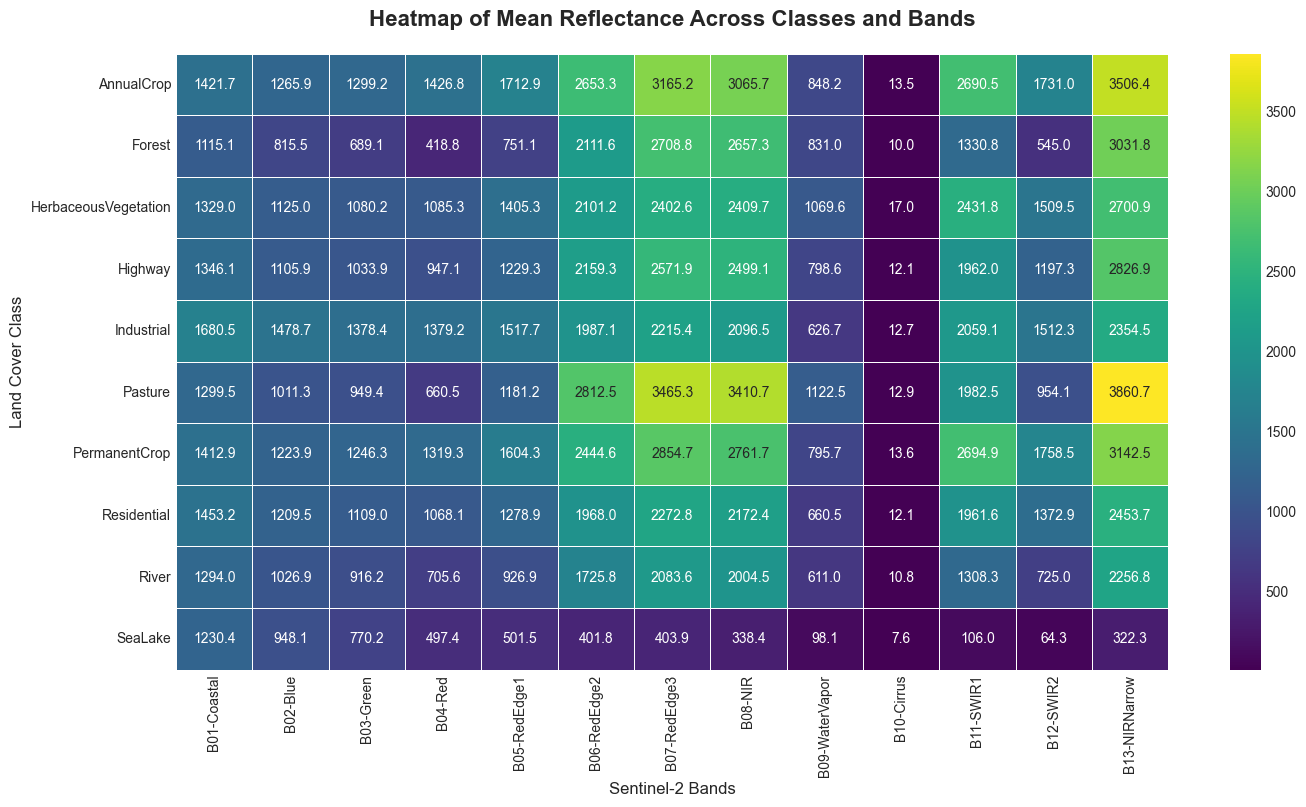

In [9]:
# ====== STEP 3.3: Aggregate Results and Create Summary ======

# Use pivot_table to group by class and calculate the mean of the 'mean' columns for each band
mean_columns = [f'b{b:02d}_mean' for b in range(1, 14)]
summary_df = df_stats.pivot_table(
    index='class',
    values=mean_columns,
    aggfunc='mean'
)

# Optional: Add band names to the columns for better readability
summary_df.columns = [f"B{i:02d}-{SENTINEL2_BANDS[i]['name'].split('-')[1]}" for i in range(1, 14)]


print("\n📋 Cross-Class Mean Reflectance Summary Table:")
display(summary_df.style.background_gradient(cmap='viridis').format("{:.1f}"))

# --- Visualize the Summary as a Heatmap ---
plt.figure(figsize=(16, 8))
sns.heatmap(
    summary_df,
    annot=True,       # Show the numerical values in each cell
    fmt=".1f",        # Format numbers to one decimal place
    cmap='viridis',     # Use a visually appealing color map
    linewidths=.5     # Add lines between cells
)
plt.title('Heatmap of Mean Reflectance Across Classes and Bands', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentinel-2 Bands', fontsize=12)
plt.ylabel('Land Cover Class', fontsize=12)
plt.show()

### Plotting the Spectral Signatures

Finally, let's plot the data from our summary table as a line graph. Each line on the graph will represent a land cover class, and the x-axis will show the 13 Sentinel-2 bands. This graph is the classic way to view and compare **spectral signatures**.

#### 💡 What to look for:
- **Vegetation Classes**: Look for a dip in the Red (B04) region and a sharp rise in the Near-Infrared (B08). This is the "red edge," a classic sign of healthy vegetation.
- **Water Classes**: Water absorbs most light, so expect these classes to have very low reflectance across almost all bands.
- **Urban/Bare Soil Classes**: These tend to have higher reflectance than vegetation in the visible spectrum and lack the sharp NIR peak.

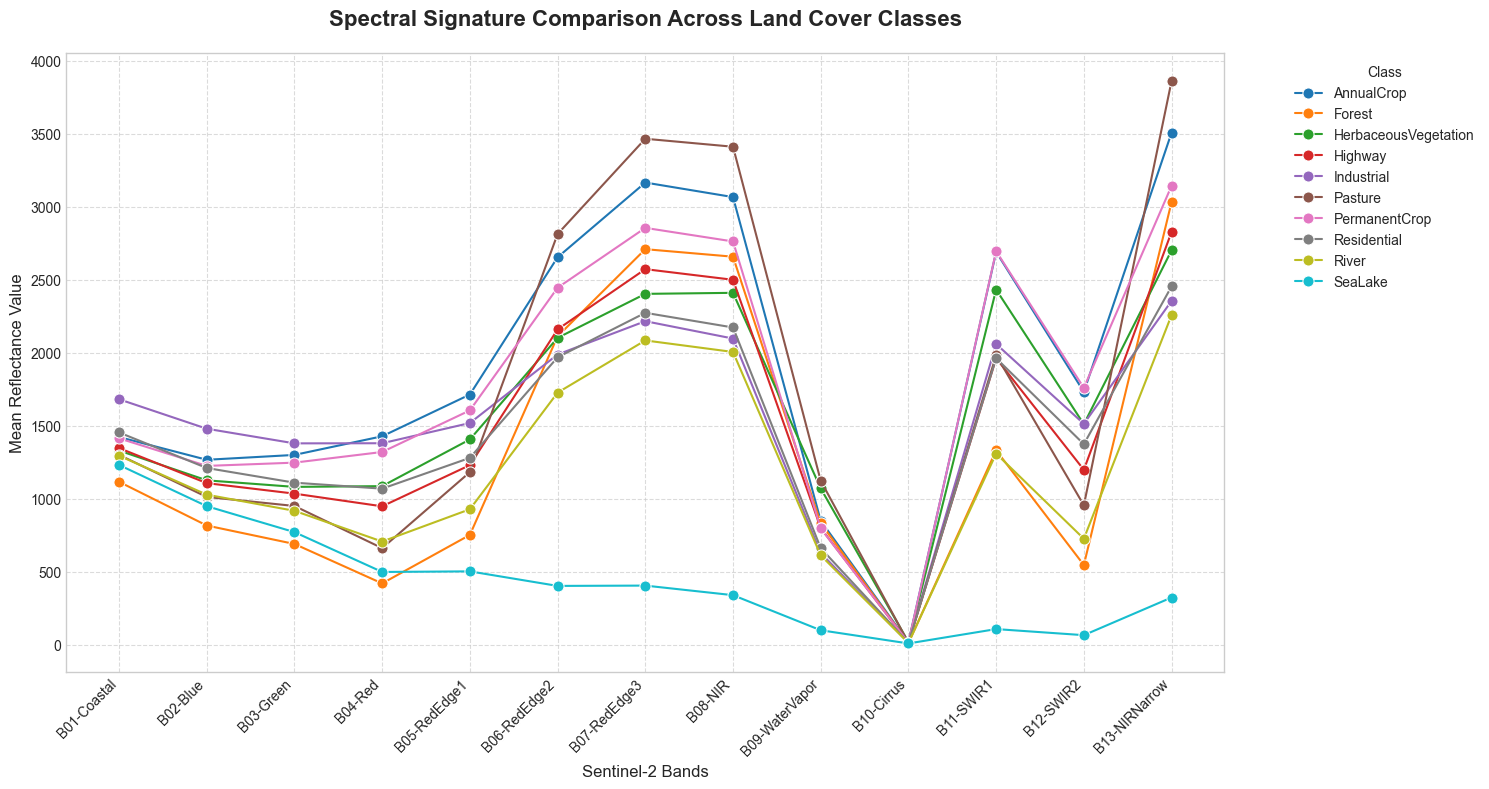

In [10]:
# ====== STEP 3.4: Plotting Spectral Signatures ======

plt.figure(figsize=(15, 8))

# Transpose the DataFrame so that bands are on the x-axis and plot each class as a line
ax = sns.lineplot(data=summary_df.T, palette="tab10", dashes=False, marker='o', markersize=8)

# --- Formatting the Plot ---
plt.title('Spectral Signature Comparison Across Land Cover Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentinel-2 Bands', fontsize=12)
plt.ylabel('Mean Reflectance Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Move the legend outside the plot area for better visibility
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() # Ensure all elements fit without overlapping
plt.show()

## 🏁 Conclusion & Key Takeaways

This notebook has provided a thorough overview of the EuroSAT multispectral dataset. We have successfully:

1.  **Validated and Profiled the Dataset**: We confirmed the structure and understood the distribution of images across 10 distinct land cover classes.

2.  **Visually Inspected Samples**: By comparing True Color images with spectral indices like NDVI and NDWI, we saw firsthand how different band calculations can highlight specific features like vegetation and water.

3.  **Quantified Spectral Signatures**: Through large-scale parallel processing, we computed the mean reflectance for each class across all 13 Sentinel-2 bands. 

The final **heatmap and spectral signature plot** clearly demonstrate that each land cover class has a distinct spectral fingerprint. These unique signatures are precisely what allows machine learning models to differentiate between a forest, a river, and a highway from space.

This foundational analysis is the first step toward building powerful land cover classification models.